In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import yaml
import numpy as np


print("loading data file, wait...")
with open('fake_liste_users_revo_130122.yaml', 'r') as data_file_content:
    users_list = yaml.load(data_file_content, Loader=yaml.FullLoader)
print("data load complete!")

print("Total number of users : ", len(users_list))


loading data file, wait...
data load complete!
Total number of users :  20000


In [3]:
df = pd.DataFrame(users_list)
print(df.head())

  acquisition_channel cancel_year_month duration_month fiber_or_adsl  \
0               phone           2019-07             42          adsl   
1              online           2018-07             18          adsl   
2               phone           2018-03             26          adsl   
3               phone               N/A            N/A         fiber   
4               phone           2019-02             37          adsl   

   has_retention                                   offer recruit_year_month  \
0          False  #11:Freebox Revolution with TV 3999eur            2016-01   
1          False  #11:Freebox Revolution with TV 3999eur            2017-01   
2          False  #11:Freebox Revolution with TV 3999eur            2016-01   
3          False  #11:Freebox Revolution with TV 3999eur            2017-01   
4          False  #11:Freebox Revolution with TV 3999eur            2016-01   

                                 sub_offer  total_bill  
0  11.4:Freebox Revolution with TV 

# I - Churn

## Question 1

In [4]:
users_recruit_month = df["recruit_year_month"].value_counts()
print(users_recruit_month)

recruit_year_month
2016-01    10452
2017-01     9548
Name: count, dtype: int64


## Question 2

In [5]:
print(f"""Il reste {(df["cancel_year_month"]=="N/A").sum()} utilisateurs en janvier 2022""")

Il reste 6569 utilisateurs en janvier 2022


                   count
cancel_year_month       
2016-01              235
2016-02              216
2016-03              125
2016-04              131
2016-05              149
...                  ...
2021-09               78
2021-10               62
2021-11               70
2021-12               74
2022-01               29

[73 rows x 1 columns]


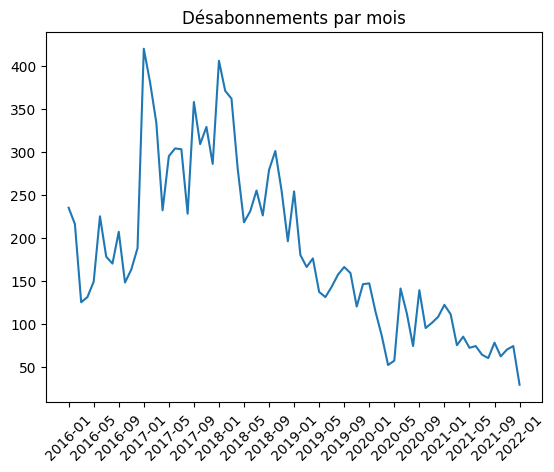

In [6]:
cancels_by_month = pd.DataFrame(df["cancel_year_month"].value_counts()[1:].sort_index())
print(cancels_by_month)
plt.plot(cancels_by_month)
plt.xticks(cancels_by_month.index[::4], rotation=45)
plt.title("Désabonnements par mois")
plt.show()

In [7]:
remain_by_duration_2016 = df[df["recruit_year_month"]=="2016-01"]["duration_month"].value_counts()
remain_by_duration_2017 = df[df["recruit_year_month"]=="2017-01"]["duration_month"].value_counts()
na_2016 = remain_by_duration_2016['N/A']
na_2017 =remain_by_duration_2017['N/A']

remain_by_duration_2016 = remain_by_duration_2016[1::].sort_index()[::-1].cumsum()[::-1] + na_2016
remain_by_duration_2017 = remain_by_duration_2017[1::].sort_index()[::-1].cumsum()[::-1] + na_2017


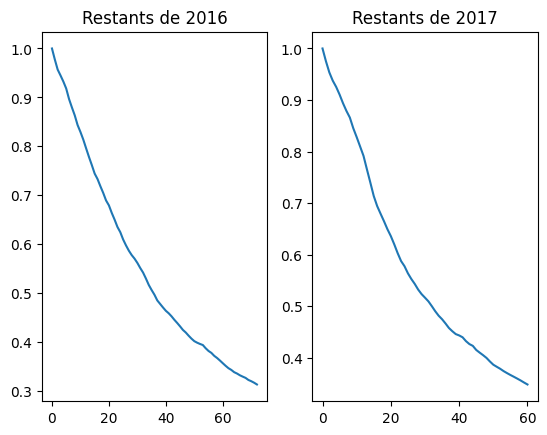

In [8]:
plt.subplot(1,2,1)
plt.plot(remain_by_duration_2016/users_recruit_month[0])
plt.title("Restants de 2016")
plt.subplot(1,2,2)
plt.plot(remain_by_duration_2017/users_recruit_month[1])
plt.title("Restants de 2017")
plt.show()


Les graphiques sont similaires pour les deux groupes

## Question 3

In [9]:
total_cancels_by_month = pd.DataFrame(cancels_by_month.cumsum())
total_registered = pd.DataFrame(cancels_by_month.copy())

total_registered.loc[total_registered.index<"2017-01"] = users_recruit_month[0]
total_registered.loc[total_registered.index>="2017-01"] = users_recruit_month.sum()

remains_by_month = total_registered - total_cancels_by_month

In [10]:
churn_rate = cancels_by_month.shift(1)/remains_by_month[1:]

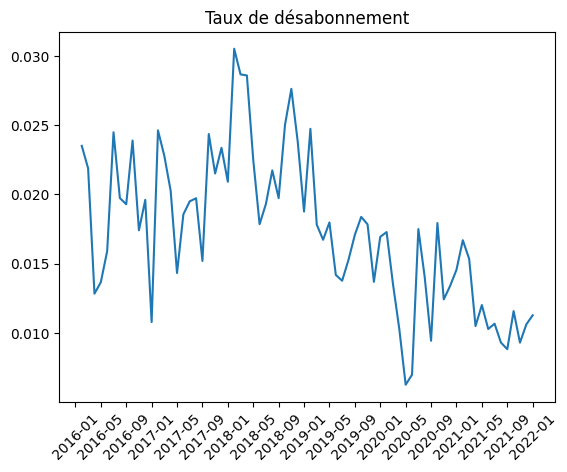

In [11]:
plt.plot(churn_rate)
plt.xticks(churn_rate.index[::4], rotation=45)
plt.title("Taux de désabonnement")
plt.show()

# II - Bills

## Question 1

In [12]:
np.round(df["total_bill"].mean(),2)

1612.2

In [13]:
print(f"""Average total bill for 01/2016 :{np.round(df[df["recruit_year_month"]=='2016-01']["total_bill"].mean(),2)}""")
print(f"""Average total bill for 01/2017 : {np.round(df[df["recruit_year_month"]=='2017-01']["total_bill"].mean(),2)}""")

print(f"""Average total bill for users using fiber : {np.round(df[df["fiber_or_adsl"]=='fiber']["total_bill"].mean(),2)}""")
print(f"""Average total bill for users using adsl : {np.round(df[df["fiber_or_adsl"]=='adsl']["total_bill"].mean(),2)}""")

Average total bill for 01/2016 :1749.53
Average total bill for 01/2017 : 1461.87
Average total bill for users using fiber : 2287.65
Average total bill for users using adsl : 1389.8


## Question 2

In [14]:
total_bill_by_tenure_2016 = df[df["recruit_year_month"]=="2016-01"].groupby("duration_month")["total_bill"].mean()[:-1]
total_bill_by_tenure_2017 = df[df["recruit_year_month"]=="2017-01"].groupby("duration_month")["total_bill"].mean()[:-1]


In [15]:
from sklearn.linear_model import LinearRegression

X2016 = np.array(total_bill_by_tenure_2016.index).reshape(-1,1)


y2016 = np.array(total_bill_by_tenure_2016)
model = LinearRegression()


model.fit(X2016, y2016)


predictions2016 = model.predict(X2016)



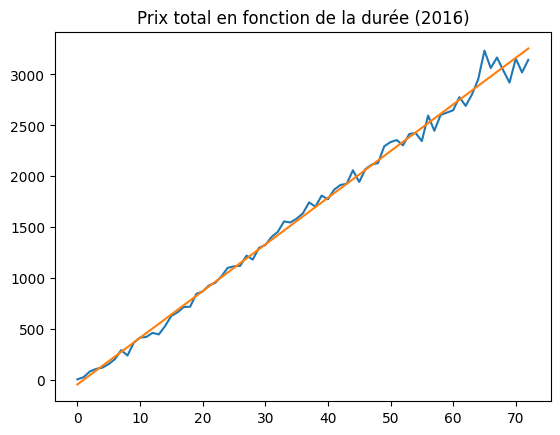

In [16]:
plt.plot(total_bill_by_tenure_2016)
plt.plot(X2016, predictions2016)
plt.title("Prix total en fonction de la durée (2016)")

plt.show()

In [17]:
from sklearn.linear_model import LinearRegression

X2017 = np.array(total_bill_by_tenure_2017.index).reshape(-1,1)


y2017 = np.array(total_bill_by_tenure_2017)
model = LinearRegression()


model.fit(X2017, y2017)


predictions2017 = model.predict(X2017)


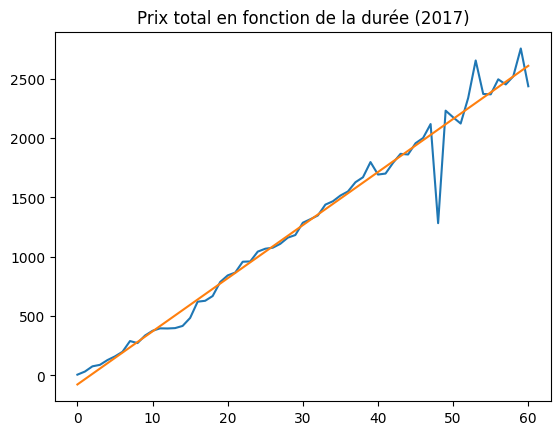

In [18]:
plt.plot(total_bill_by_tenure_2017)
plt.plot(X2017, predictions2017)
plt.title("Prix total en fonction de la durée (2017)")

plt.show()

We see that the longer the duration is, the higher the total bill is which logical

# Churn prediction

Première idée : on définit le prix moyen par mois, car un utilisateur qui paye trop chère aurait tendance à changer d'opérateur

C:\Users\artem\AppData\Local\Temp\ipykernel_4860\1520976817.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0["monthly_bill"] = (df0["total_bill"]/df0["duration_month"]).values


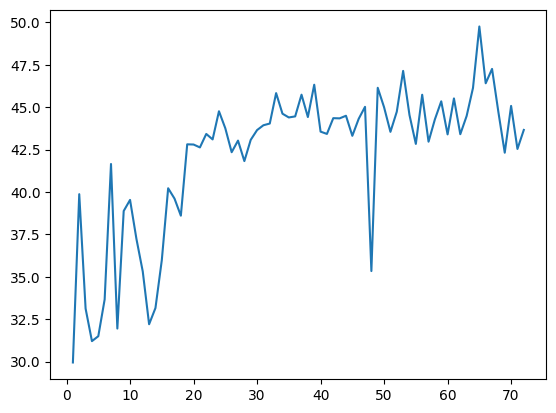

In [19]:
df2 = df.replace('N/A', pd.NA)

# Drop rows with NaN values
df2 = df2.dropna()

df0 = df2[df2["duration_month"]!=0]
df0["monthly_bill"] = (df0["total_bill"]/df0["duration_month"]).values
mean_bill = df0.groupby("duration_month")["monthly_bill"].mean()
plt.plot(mean_bill)

On n'obtient pas une corrélation concluante

### Deuxième idée : arbre de décision

On ajoute d'abord une colonne "Churn" qui indique si l'utilisateur a résigné.

In [20]:
df3 = df.copy()

def has_churned(l):
    duration_month = l["duration_month"]

    if duration_month == "N/A":
        return True
    else:
        return False

np.vectorize(has_churned)
    
df3["Churn"] = df3[["duration_month"]].apply(has_churned, axis=1)

In [21]:
dm = pd.get_dummies(df3[["acquisition_channel","fiber_or_adsl",
  "offer",
  "recruit_year_month",
  "sub_offer"]])

df3 = df3.drop(["acquisition_channel","fiber_or_adsl",
  "offer",
  "recruit_year_month",
  "sub_offer", "total_bill"], axis=1)
df3 = pd.concat([df3, dm], axis=1)
df3 = df3.drop(["cancel_year_month", "duration_month"], axis=1)
df3.head()

,has_retention,Churn,acquisition_channel_mail,acquisition_channel_online,acquisition_channel_other,acquisition_channel_outgoing call,acquisition_channel_outgoing call - promo,acquisition_channel_phone,acquisition_channel_pos,fiber_or_adsl_adsl,fiber_or_adsl_fiber,offer_#11:Freebox Revolution with TV 3999eur,offer_#8:Freebox Revolution 2999eur,recruit_year_month_2016-01,recruit_year_month_2017-01,sub_offer_11.4:Freebox Revolution with TV 3999eur,sub_offer_8.2:Freebox Revolution 2999eur,sub_offer_8.57:Freebox Revolution 2999eur | Promo : 999eur for 1 year
0,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,False
1,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,True,False,False
2,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,False
3,False,True,False,False,False,False,False,True,False,False,True,True,False,False,True,True,False,False
4,False,False,False,False,False,False,False,True,False,True,False,True,False,True,False,True,False,False


In [22]:
from sklearn.model_selection import train_test_split
y = df3["Churn"]
X_train,X_test,y_train,y_test = train_test_split(df3.drop("Churn", axis=1),y,test_size=0.2)


In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier()

In [24]:
model.fit(X_train,y_train)


DecisionTreeClassifier()

In [25]:
predict_train = model.predict(X_test)
trainaccuracy = accuracy_score(y_test,predict_train)
print('accuracy_score on train dataset : ', trainaccuracy)


accuracy_score on train dataset :  0.7605


On obtient une précision autour de 75% qui n'est pas entièrement satisfaisante, mais déjà bien meilleur que l'aléatoire, et qui peut permettre de proposer des promotions aux utilisateurs qui s'apprètent à résilier.

### Retention offer

In [26]:
print(df[df["has_retention"]==True]["duration_month"].replace('N/A', pd.NA).dropna().mean())
print(df[df["has_retention"]==False]["duration_month"].replace('N/A', pd.NA).dropna().mean())

52.76923076923077
22.670926997970078


On remarque l'offre de rétention double la durée d'abonnement des utilisateurs

Text(0.5, 1.0, 'Avec offre de rétention')

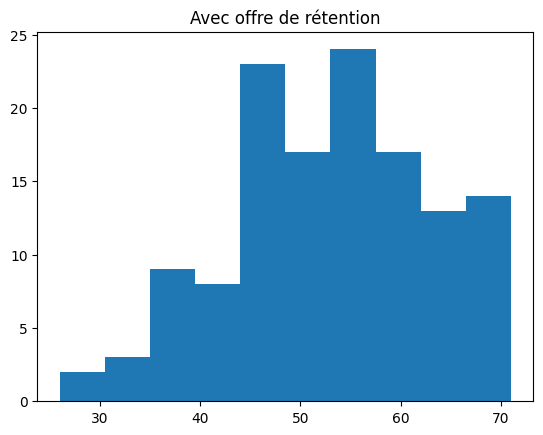

In [27]:
plt.hist(df[df["has_retention"]==True]["duration_month"].replace('N/A', pd.NA).dropna())
plt.title("Avec offre de rétention")

Text(0.5, 1.0, 'Sans offre de rétention')

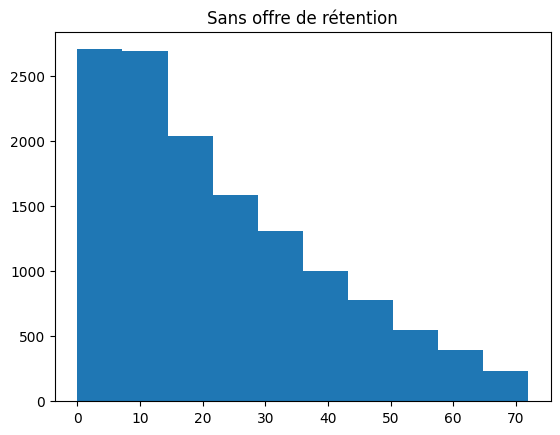

In [28]:
plt.hist(df[df["has_retention"]==False]["duration_month"].replace('N/A', pd.NA).dropna())
plt.title("Sans offre de rétention")

On voit ici que dans le cas d'une offre de rétention il a peu d'utilisateur qui résilient dans les premiers mois